<a href="https://colab.research.google.com/github/RFdream/ML100-Days/blob/master/Data/Day099_data_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline

Using TensorFlow backend.


In [0]:
# 此函數會幫我們把多張影像畫成一張多宮格圖
def img_combine(img, ncols=8, size=1, path=False):
    from math import ceil
    import matplotlib.pyplot as plt
    import numpy as np
    nimg = len(img)
    nrows = int(ceil(nimg/ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols*size,nrows*size))
    if nrows == 0:
        return
    elif ncols == 1:
        for r, ax in zip(np.arange(nrows), axes):
            nth=r
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                
            ax.set_axis_off()
    elif nrows == 1:
        for c, ax in zip(np.arange(ncols), axes):
            nth=c
            if nth < nimg:
                ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
            ax.set_axis_off()
    else:
        for r, row in zip(np.arange(nrows), axes):
            for c, ax in zip(np.arange(ncols), row):
                nth=r*ncols+c
                if nth < nimg:
                    ax.imshow(img[nth], cmap='rainbow', vmin=0, vmax=1)
                ax.set_axis_off()
    plt.show()

In [0]:
# 讀取 Cifar-10 資料集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

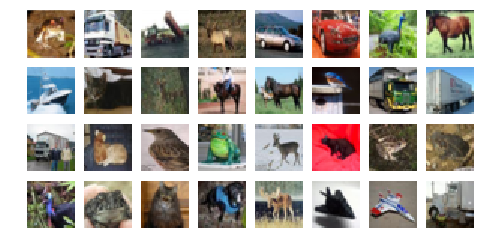

In [4]:
# 取前 32 張圖片做視覺化
images = x_train[:32]
img_combine(images)

In [0]:
# 建立 ImageDataGenerator，並指定我們要做資料增強的數值範圍
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

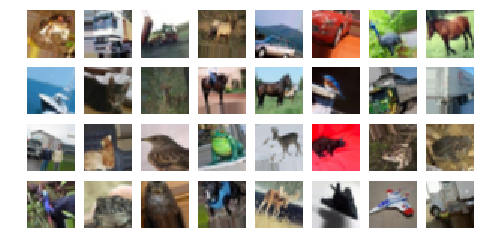

In [6]:
# 注意！！ ImageDataGenerator 是一個 Generator (生成器)! 對 Generator 不熟悉的同學請回到 Day098 做複習。
# 使用 .flow 後，就會對我們的影像進行增強，再 call next 取出 generator 的圖像。(shuffle=False 因為我們希望圖像的順序不要改變，方便觀察。實際訓練時預設是 shuffle=True) 
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int")) # 注意在訓練時神經網路時，圖像資料必須要是 float32，但在做視覺化時要轉為 int 才能順利畫圖。所以為了畫圖才把資料轉為 int

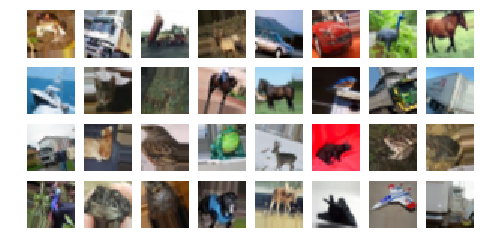

In [7]:
# 因為隨機性的關係，所以一樣的圖像再經過一次 generator 後的結果不一定相同
augmented_iamges = next(data_generator.flow(images, shuffle=False))
img_combine(augmented_iamges.astype("int"))

## 作業

請使用 ImageDataGenerator 來進行 Cifar-10 資料集的訓練，並觀察不同的圖像增強方法是否會顯著影響訓練結果

In [0]:
from math import ceil
import keras
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Activation, MaxPooling2D, Dropout, Flatten
from keras.optimizers import RMSprop

In [9]:
num_classes = 10

def build_model(input_shape):
    model = Sequential([
        Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        Activation('relu'),
        Conv2D(32, (3, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Conv2D(64, (3, 3), padding='same',),
        Activation('relu'),
        Conv2D(64, (3, 3)),
        Activation('relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),
        
        Flatten(),
        Dense(512),
        Activation('relu'),
        Dropout(0.5),
        Dense(num_classes),
        Activation('softmax')
    ])
    
    optimizer = RMSprop(lr=1e-4, decay=1e-6)
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=optimizer)
    
    return model

build_model(x_train.shape[1:]).summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)  

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [0]:
batch_size = 32
epochs = 100
import matplotlib.pyplot as plt
%matplotlib inline

def plot(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    
    ax[0].plot(loss, linestyle='-')
    ax[0].plot(val_loss, linestyle='--')
    ax[0].set_ylabel('Loss')
    
    ax[1].plot(acc, linestyle='-')
    ax[1].plot(val_acc, linestyle='--')
    ax[1].set_ylabel('Accuracy')
    
    plt.tight_layout()
    plt.show()

In [0]:
def compare_train(data_generator):
    model = build_model(input_shape=x_train.shape[1:])

    data_generator.fit(x_train)

    history = model.fit_generator(
        data_generator.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=ceil(x_train.shape[0] / batch_size),
        epochs=epochs,
        validation_data=(x_test, y_test),
        workers=4,
        verbose=0,
    )

    loss, acc = model.evaluate(x_test, y_test)
    print('loss: ', loss)
    print('acc: ', acc)
    
    return history

Instructions for updating:
Use tf.cast instead.
10000/10000 [==============================] - 1s 74us/step
loss:  0.8526764271736145
acc:  0.7161


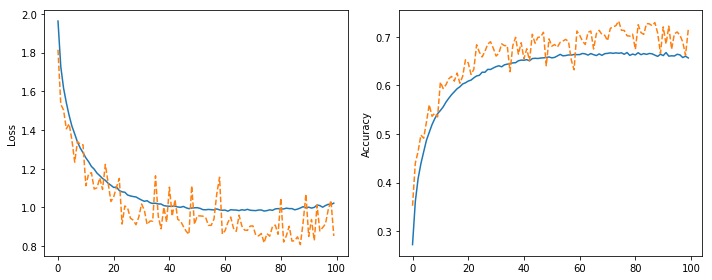

In [13]:
data_generator = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

history = compare_train(data_generator)
plot(history)

10000/10000 [==============================] - 1s 87us/step
loss:  0.7564338208198548
acc:  0.7433


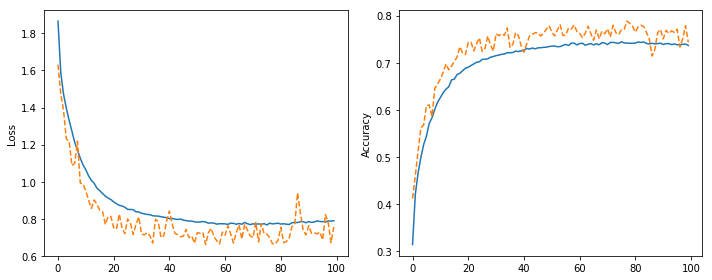

In [15]:
data_generator = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    zca_epsilon=1e-06,  # epsilon for ZCA whitening
    rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
    # randomly shift images horizontally (fraction of total width)
    width_shift_range=0.1,
    # randomly shift images vertically (fraction of total height)
    height_shift_range=0.1,
    shear_range=0.,  # set range for random shear
    zoom_range=0.,  # set range for random zoom
    channel_shift_range=0.,  # set range for random channel shifts
    # set mode for filling points outside the input boundaries
    fill_mode='nearest',
    cval=0.,  # value used for fill_mode = "constant"
    horizontal_flip=True,  # randomly flip images
    vertical_flip=False,  # randomly flip images
    # set rescaling factor (applied before any other transformation)
    rescale=None,
    # set function that will be applied on each input
    preprocessing_function=None,
    # image data format, either "channels_first" or "channels_last"
    data_format=None,
    # fraction of images reserved for validation (strictly between 0 and 1)
    validation_split=0.0
)

history = compare_train(data_generator)
plot(history)